## Joseph Farag

# Forecasting Time Series Analysis with Netflix Stock Data


In this project, we aim to forecast future predictions of the netflix stock values based on previous data. The dataset we use contains the daily close for the Netflix stock value from 2018-2022. Using this data, we'll run some analysis to establish a model that can accurately predict future values.

Firstly we read in the data and do some initial data cleaning to establish a dataframe upon which we can run analysis.

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
netflix = pd.read_csv(r"C:\Users\joefa\OneDrive\Documents\Projects\NFLX.csv")
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [22]:
netflix['Date'] = pd.to_datetime(netflix['Date'], format='%Y-%m-%d')
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [23]:
netflix.index = netflix['Date']
del netflix['Date'] #delete unnecessary columns
del netflix['Open']
del netflix['High']
del netflix['Low']
del netflix['Adj Close']
del netflix['Volume']

In [24]:
netflix.tail()

,Close
Date,
2022-01-31,427.140015
2022-02-01,457.130005
2022-02-02,429.480011
2022-02-03,405.600006
2022-02-04,410.170013


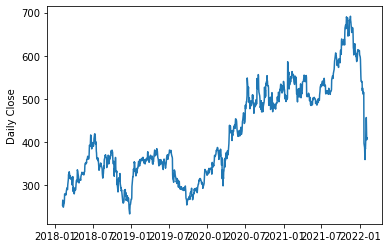

In [25]:
import seaborn as sns
plt.plot(netflix.index, netflix['Close'], )
plt.ylabel("Daily Close")
plt.show()

After cleaning our data, we are left with our plot above. We'll use the data we've got and split it into a training and test dataset upon which we'll forecast predictions and test the accuracy of our model. We initially split our data below.

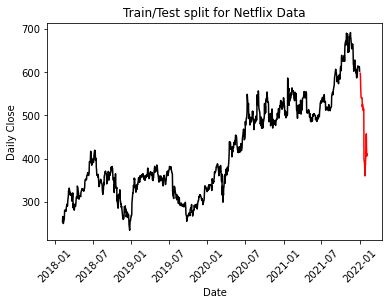

In [26]:
train = netflix[netflix.index < pd.to_datetime("2022-01-01", format='%Y-%m-%d')] #setting train and test datasets
test = netflix[netflix.index > pd.to_datetime("2022-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Daily Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Netflix Data")
plt.show()

The first model we'll use to form a model is the ARMA (Autoregressive Moving Average) model. This model uses past values to predict future ones, as the predicted values are a weighted linear combination of past values. We define an ARMA model with order parameters (1,0,1).

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = train['Close']
ARMAmodel = SARIMAX(y, order = (1,0,1))
ARMAmodel = ARMAmodel.fit()

In [28]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

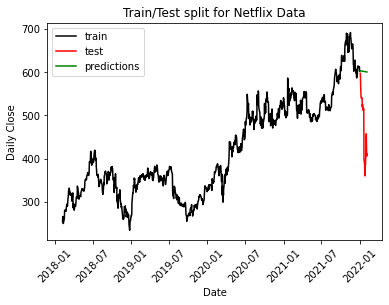

In [29]:
plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(y_pred_out, color='green', label = 'predictions')
plt.ylabel('Daily Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Netflix Data")
plt.legend()
plt.show()

In [30]:
import numpy as np 
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test['Close'].values, y_pred_df['Predictions']))
print("RMSE: ", arma_rmse)

RMSE:  145.0669487808952


By analysing our plot above, we can see our predictions aren't exceptionally accurate. Our root mean-squared error confirms this and we aim to find a more accurate model. To do this we instead try using a ARIMA (Autoregressive Integrated Moving Average) model. Through trial and error we found the order parameters (5,4,2) were most suitable.

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [32]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = ARIMAmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

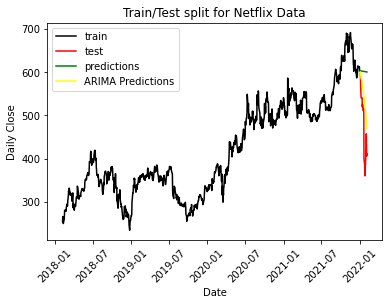

In [33]:
plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(y_pred_out, color='green', label = 'predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.ylabel('Daily Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Netflix Data")
plt.legend()
plt.show()

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df2["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  82.0922443198398


This plot looks incredibly more accurate and is confirmed by our RMSE statistic. We try one more model to test for seasonality in our SARIMA model below.

In [35]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

In [36]:
y_pred3 = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df3 = y_pred3.conf_int(alpha = 0.05) 
y_pred_df3["Predictions"] = SARIMAXmodel.predict(start = y_pred_df3.index[0], end = y_pred_df3.index[-1])
y_pred_df3.index = test.index
y_pred_out3 = y_pred_df3["Predictions"] 

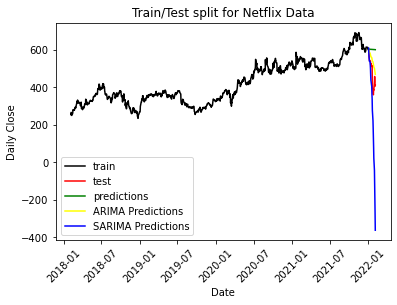

In [37]:
plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(y_pred_out, color='green', label = 'predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_out3, color='Blue', label = 'SARIMA Predictions')
plt.ylabel('Daily Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Netflix Data")
plt.legend()
plt.show()

In [38]:
sarima_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df3["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  318.4930601927225


By observing the plot and the RMSE, this is our least accurate model of the bunch, and thus we'll stick with our ARIMA model in predicting future values

### Conclusions
Time series forcaasting is important for predicting future values of stocks, in particular Netflix stock values in this case. From our project, we can see our ARIMA model is the most accurate for future predictions of the data, and is what we'll use in future uses.